In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, make_scorer, f1_score, roc_auc_score, det_curve
from sklearn import preprocessing
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, PredefinedSplit, GridSearchCV
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
import json
import random as rnd

%matplotlib inline

In [2]:
def update_dict(d, u):
    import collections.abc
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d


def update_file_with_results(file_path, results_dict):
    with open(file_path, 'r') as f:
        res = json.load(f)
    
    res = update_dict(res, results_dict)
    
    with open(file_path, 'w') as f:
        json.dump(res, f, sort_keys=True, indent=2)
        
        
def get_dict_with_results(json_path):
    with open(json_path, 'r') as f:
        res = json.load(f)
    return res 

In [3]:
def eer(fpr, fnr, thresholds):
    idx = np.nanargmin(np.absolute((fnr - fpr)))
    eer_threshold = thresholds[idx]
    eer1 = fpr[idx]
    
    return eer1, eer_threshold


def auc_roc(fpr, tpr):
    return metrics.auc(fpr, tpr)


def confusion_matrix_thr(y_true, proba, threshold):
    predict = proba
    predict[predict > threshold] = 1
    predict[predict <= threshold] = 0
    
    matr = metrics.confusion_matrix(y_true, predict, labels=[0, 1])
    
    tp = matr[0, 0]
    fp = matr[1, 0]
    fn = matr[0, 1]
    tn = matr[1, 1]
    
    return tn, fp, fn, tp


def anga_ania(y_test, proba, events_count, threshold):
    predict = [1  if x > threshold else 0 for x in proba]
    anga_value = 0
    anga_val_s = False
    ania_value = 0
    ania_value_s = False
    for target, prediction, ev_count in zip(y_test, predict, events_count):
        if target == 1:
            if anga_val_s is False:
                anga_value += ev_count
            if prediction != 1:
                anga_val_s = True
        else:
            if ania_value_s is False:
                ania_value += ev_count
            if prediction != 1:
                ania_value_s = True
                
    if anga_val_s is False:
        anga_value = -1
        
    if ania_value_s is False:
        ania_value = -1
        
    return anga_value, ania_value


def calc_metrics(y_test, proba, events_count, thresholds):
    FPR = np.array([])
    TPR = np.array([])
    FNR = np.array([])
    F_score = np.array([])
    ANGA = np.array([])
    ANIA = np.array([])

    for thr in thresholds:
        tn, fp, fn, tp = confusion_matrix_thr(y_test, proba.copy(), thr)
        
        fpr = fp / (tn + fp)
        tpr = tp / (tp + fn)
        fnr = fn / (tp + fn)
        
        FPR = np.append(FPR, 1 if np.isnan(fpr) else fpr)
        TPR = np.append(TPR, 1 if np.isnan(tpr) else tpr)
        FNR = np.append(FNR, 1 if np.isnan(fnr) else fnr)
        F_score = np.append(F_score, tp / (tp + 0.5 * (fn + fp)))
        anga, ania = anga_ania(y_test, proba, events_count, thr)
        ANGA = np.append(ANGA, anga)
        ANIA = np.append(ANIA, ania)
    
    EER, EER_thr = eer(fpr=FPR, fnr=FNR, thresholds=thresholds)
    AUC_ROC = auc_roc(fpr=FPR, tpr=TPR)
    
    return {'FAR': FPR, 
            'FRR': FNR, 
            'F': F_score, 
            'ANGA': ANGA, 
            'ANIA': ANIA, 
            'EER': EER, 
            'EER_thr': EER_thr, 
            'AUC-ROC': AUC_ROC}


def iterate_over_results(results):
    for df_type, inner in results.items():
        if df_type == 'stub':
            continue

        for window_type, inner1 in inner.items():
            for window_size, inner2 in inner1.items():
                for model, inner3 in inner2.items():
                    for valid_user, inner4 in inner3['valid_user'].items():
                        for intruder, inner5 in inner4['intruder'].items():
                            for index_1, inner6 in inner5['valid_sample_index'].items():
                                for index_2, inner7 in inner6['intruder_sample_index'].items():
                                    yield {'df_type': df_type, 
                                           'window_type': window_type, 
                                           'window_size': window_size, 
                                           'model': model, 
                                           'valid_user': valid_user, 
                                           'intruder': intruder, 
                                           'index_1': index_1, 
                                           'index_2': index_2, 
                                           'test': np.array(inner7['test']), 
                                           'proba': np.array(inner7['proba'])[:, 1], 
                                           'events_count': np.array(inner7['events_count'])}
                                    
                                    
def avg_common_metrics(results, thresholds):
    metrics = {}
    for res in iterate_over_results(results):
        key = (res['df_type'], res['window_type'], res['window_size'], res['model'])
        if key not in metrics.keys():
            metrics[key] = {'EER': [], 'AUC-ROC': []}
        
        metrics_dict = calc_metrics(res['test'], res['proba'], res['events_count'], thresholds)
        
        metrics[key]['AUC-ROC'].append(metrics_dict['AUC-ROC'])
        
    for k, v in metrics.items():
        metrics[k] = (np.array(v['EER']).mean(), 
                      np.array(v['AUC-ROC']).mean())
    
    return metrics



In [ ]:
def extract_results_for_each_pair(results, model, window_type, window_size):
    res_dict = dict()
    for res in iterate_over_results(results):
        if res['model'] == model and res['window_type'] == window_type and res['window_size'] == window_size:
            valid_user = res['valid_user']
            intruder = res['intruder']
            if valid_user not in res_dict.keys():
                res_dict[valid_user] = dict()
            if intruder not in res_dict[valid_user].keys():
                res_dict[valid_user][intruder] = {'test': [], 'proba': [], 'events_count': []}

            res_dict[valid_user][intruder]['test'].append(res['test'])
            res_dict[valid_user][intruder]['proba'].append(res['proba'])
            res_dict[valid_user][intruder]['events_count'].append(res['events_count'])
        
    return res_dict


def train_test_split(extracted_results, valid_user, intruder, test_size):
    test = extracted_results[valid_user][intruder]['test']
    proba = extracted_results[valid_user][intruder]['proba']
    events_count = extracted_results[valid_user][intruder]['events_count']
    
    test_count = int(test_size * len(test))
    train_count = len(test) - test_count
    
    indexes = [x for x in range(len(test))]
    
    test_idxs = random.sample(indexes, test_count)
    train_idxs = [x for x in indexes if x not in test_idxs]
    
    test_arr = [(test[i], proba[i], events_count[i]) for i in test_idxs]
    
    train_test_array = []
    train_proba_array = []
    for t, p in [(test[i], proba[i]) for i in train_idxs]:
        train_test_array += t
        train_proba_array += p
        
    train_array = np.array(train_test_array, train_proba_array).T
    
    return train_array, test_arr


def unite_train(wifi, bt, location):
    wifi_df = pd.DataFrame(wifi, columns=['wifi_test', 'wifi_proba'])
    bt_df = pd.DataFrame(bt, columns=['bt_test', 'bt_proba'])
    location_df = pd.DataFrame(location, columns=['location_test', 'location_proba'])
    
    valid_union = pd.concat([wifi_df[wifi_df['wifi_test'] == 1], 
                   bt_df[bt_df['bt_test'] == 1], 
                   location_df[location_df['location_test'] == 1]], axis=1).dropna()
        
    intruder_union = pd.concat([wifi_df[wifi_df['wifi_test'] != 1], 
                   bt_df[bt_df['bt_test'] != 1], 
                   location_df[location_df['location_test'] != 1]], axis=1).dropna()
        
    union = pd.concat([valid_union, intruder_union])
    union['test'] = union['wifi_test'] + union['bt_test'] + union['location_test']
    union.loc[union['test'] == 4, 'test'] = 1
    union.loc[union['test'] != 4, 'test'] = 0
    
    union = union.drop(['wifi_test', 'bt_test', 'location_test'], axis=1)
    
    X = union.to_numpy().copy()[:, :-1]
    y = union.to_numpy().copy()[:, -1]
    
    return X, y


def unite_test(wifi, bt, location):
    count = min(len(wifi), len(bt), len(location))
    test_list = []
    
    for i in range(count):

        wifi_df = pd.DataFrame(np.array(list(wifi[i])).T, columns=['wifi_test', 'wifi_proba', 'wifi_events_count'])
        bt_df = pd.DataFrame(np.array(list(bt[i])).T, columns=['bt_test', 'bt_proba', 'bt_events_count'])
        location_df = pd.DataFrame(np.array(list(location[i])).T, columns=['location_test', 'location_proba', 'location_events_count'])

    
        valid_union = pd.concat([wifi_df[wifi_df['wifi_test'] == 1], 
                       bt_df[bt_df['bt_test'] == 1], 
                       location_df[location_df['location_test'] == 1]], axis=1).dropna()
        
        intruder_union =  pd.concat([wifi_df[wifi_df['wifi_test'] != 1], 
                       bt_df[bt_df['bt_test'] != 1], 
                       location_df[location_df['location_test'] != 1]], axis=1).dropna()

        union = pd.concat([valid_union, intruder_union])
        
        union['events_count'] = union['wifi_events_count'] + union['bt_events_count'] + union['location_events_count']
        
        union['test'] = union['wifi_test'] + union['bt_test'] + union['location_test']
        union.loc[union['test'] == 4, 'test'] = 1
        union.loc[union['test'] != 4, 'test'] = 0

        union = union.drop(['wifi_test', 'bt_test', 'location_test', 
                            'wifi_events_count', 'bt_events_count', 'location_events_count'], axis=1)
        
        print(union.columns)
        
        X = union.to_numpy().copy()[:, :-2]
        y = union.to_numpy().copy()[:, -1]
        events_count = union.to_numpy().copy()[:, -2]
        
        test_list.append((X, y, events_count))
        
    return test_list


def learn_model(
        new_model,
        valid_user, 
        intruder, 
        model, 
        window_type, 
        window_size, 
        wifi_results, 
        bt_results, 
        location_results):
    
    wifi_res = extract_results_for_each_pair(wifi_results, model, window_type, window_size)
    bt_res = extract_results_for_each_pair(bt_results, model, window_type, window_size)
    location_results = extract_results_for_each_pair(location_results, model, window_type, window_size)
                                                   
    wifi_train, wifi_test = train_test_split(wifi_res, valid_user, intruder, 0.3)
    bt_train, bt_test = train_test_split(bt_res, valid_user, intruder, 0.3)
    location_train, location_test = train_test_split(location_res, valid_user, intruder, 0.3)
    
    X_train, y_train = unite_train(wifi_train, bt_train, location_train)
    test_dataset = unite_test(wifi_test, bt_test, location_test)
    
    new_model.fit(X_train, y_train)
    
    results = []
    for test_set in test_dataset:
        results.append(test_set[1], new_model.predict_proba(test_set[0]), test_set[2])
        
    return results

In [4]:
seed = int(rnd.SystemRandom().random() * 10000)
rnd.seed(a=seed)

In [11]:
MODELS = ['CatBoost', 'RandomForest', 'LogReg']
WINDOW_TYPES = ['rolling', 'sampling']
WINDOWS = ['5s', '10s', '30s', '60s', '90s', '120s', '240s', '600s']
USERS_COUNT = 8

model = LogisticRegression()

for tag in MODELS:
    for wnd_type in WINDOW_TYPES:
        for wnd in WINDOWS:
            for valid_user in range(1, USERS_COUNT + 1)
                for intruder in range(1, USERS_COUNT + 1):
                    if valid_user != intruder:
                        res = learn_model(
                            tag,
                            valid_user, 
                            intruder, 
                            model, 
                            wnd_type, 
                            wnd, 
                            wifi_results, 
                            bt_results, 
                            location_results, 
                            broadcasts_results)
                        
                        for r in res:
                            calc_metrics(res[0], res[1], res[2], THRESHOLDS)

In [63]:
RESULTS_PATH = ".\\_results"
RESULTS_FILE = 'wifi_results.json'

THRESHOLDS = np.arange(0.0, 1.01, 0.05)

results = get_dict_with_results(os.path.join(RESULTS_PATH, RESULTS_FILE))

In [ ]:
WINDOW_TYPES = ['rolling', 'sampling']
WINDOWS = ['5s', '10s', '30s', '60s', '90s', '120s', '240s', '600s']

In [65]:
avg_common_metrics(results, THRESHOLDS)

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:70

{('wifi', 'rolling', '60s', 'RandomForest'): (0.17603414890889743,
  0.0398187583035773,
  0.8351812416964227,
  115.80295018090732),
 ('wifi', 'sampling', '60s', 'RandomForest'): (0.19601648351648351,
  0.05635883131418846,
  0.8186411686858115,
  94.19278996865204)}

In [8]:
i = 0
ANIA = []
ANGA = []



for df_type, inner in results.items():
    if df_type == 'stub':
        continue
        
    for window_type, inner1 in inner.items():
        for window_size, inner2 in inner1.items():
            for model, inner3 in inner2.items():
                for valid_user, inner4 in inner3['valid_user'].items():
                    for intruder, inner5 in inner4['intruder'].items():
                        for index_1, inner6 in inner5['valid_sample_index'].items():
                            for index_2, inner7 in inner6['intruder_sample_index'].items():
                                y_test = np.array(inner7['test'])
                                proba = np.array(inner7['proba'])[:, 1]
                                events_count = np.array(inner7['events_count'])
                                
                                metrics_dict = calc_metrics(y_test, proba, events_count, thresholds)
                                
                                ANIA.append(metrics_dict['ANIA'])
                                ANGA.append(metrics_dict['ANGA'])
                                
                       

In [148]:
ANIA = np.array(ANIA)

In [149]:
ANIA[ANIA == -1] = np.nan

In [150]:
ANIA_mean = np.nanmean(ANIA, axis=0)

In [151]:
ANGA = np.array(ANGA)
ANGA[ANGA == -1] = np.nan
ANGA_mean = np.nanmean(ANGA, axis=0)

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


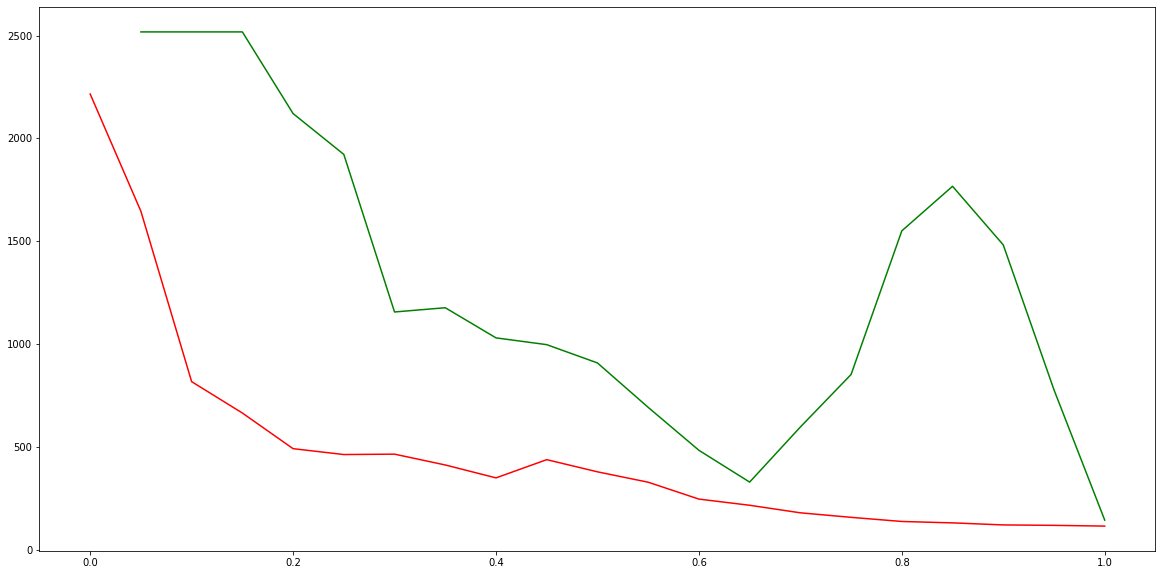

In [152]:
plt.figure(figsize=(20,10))
# plt.ylim([0, 250])

plt.plot(thresholds, ANGA_mean, "g")
plt.plot(thresholds, ANIA_mean, "r")

plt.show() 

In [ ]:
FPR = []
FNR = []
thresholds = np.arange(0.0, 1.0, 0.01)

In [ ]:
for thr in thresholds:
    tn, fp, fn, tp = confusion_matrix_thr(y_test, proba[:, 1].copy(), thr).ravel()
    FPR.append(fp / (fp + tn))
    FNR.append(fn / (fn + tp))

In [ ]:
import matplotlib.pyplot as plt
plt.title('Error rates')
plt.plot(thresholds, FPR, 'b')
plt.plot(thresholds, FNR, 'g')
plt.legend(loc = 'lower right')
plt.ylabel('Error rate')
plt.xlabel('Threshold')
plt.show()

In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('DET')
plt.plot(FPR, FNR, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('false rejection rate')
plt.xlabel('false acceptance rate')
plt.show()

In [ ]:
plot_roc_curve(model, X_test, y_test)